In [1]:
import xgboost
import numpy as np
import shap

/home/jarek/projects/shap/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# simulate some binary data and a linear outcome with an interaction term
# note we make the features in X perfectly independent of each other to make
# it easy to solve for the exact SHAP values
N = 2000
X = np.zeros((N,5))
X[:1000,0] = 1
X[:500,1] = 1
X[1000:1500,1] = 1
X[:250,2] = 1
X[500:750,2] = 1
X[1000:1250,2] = 1
X[1500:1750,2] = 1
X[:,0:3] -= 0.5
y = 2*X[:,0] - 3*X[:,1]

In [3]:
# ensure the variables are independent
np.cov(X.T)

# array([[0.25012506, 0.        , 0.        , 0.        , 0.        ],
#        [0.        , 0.25012506, 0.        , 0.        , 0.        ],
#        [0.        , 0.        , 0.25012506, 0.        , 0.        ],
#        [0.        , 0.        , 0.        , 0.        , 0.        ],
#        [0.        , 0.        , 0.        , 0.        , 0.        ]])


array([[0.25012506, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.25012506, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.25012506, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [4]:
# and mean centered
X.mean(0)

# array([0., 0., 0., 0., 0.])

array([0., 0., 0., 0., 0.])

In [5]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({
    'eta':1, 'max_depth':3, 'base_score': 0, "lambda": 0
}, Xd, 1)
print("Model error =", np.linalg.norm(y-model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

# Model error = 0.0
# 0:[f1<0] yes=1,no=2,missing=1,gain=4500,cover=2000
#         1:[f0<0] yes=3,no=4,missing=3,gain=1000,cover=1000
#                 3:leaf=0.5,cover=500
#                 4:leaf=2.5,cover=500
#         2:[f0<0] yes=5,no=6,missing=5,gain=1000,cover=1000
#                 5:leaf=-2.5,cover=500
#                 6:leaf=-0.5,cover=500

Model error = 0.0
0:[f1<0] yes=1,no=2,missing=1,gain=4500,cover=2000
	1:[f0<0] yes=3,no=4,missing=3,gain=1000,cover=1000
		3:leaf=0.5,cover=500
		4:leaf=2.5,cover=500
	2:[f0<0] yes=5,no=6,missing=5,gain=1000,cover=1000
		5:leaf=-2.5,cover=500
		6:leaf=-0.5,cover=500



In [6]:
# make sure the SHAP values add up to marginal predictions
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

# 0.0

0.0

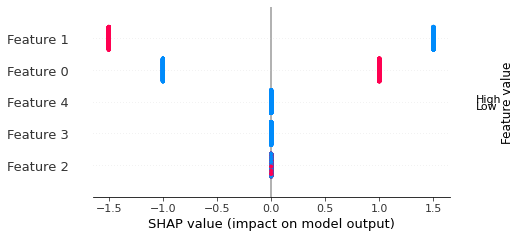

In [7]:
shap.summary_plot(shap_values, X)

# now we make a banzhaf value model

In [8]:
# from shap.explainers import pytree

# banz_explainer = pytree.BanzTreeExplainer(model)
# shap_values = banz_explainer.shap_values(Xd)
# np.abs(shap_values.sum(1) + banz_explainer.expected_value - pred).max()


In [9]:
# shap.summary_plot(shap_values, X)
shap_values

array([[ 1. , -1.5,  0. ,  0. ,  0. ],
       [ 1. , -1.5,  0. ,  0. ,  0. ],
       [ 1. , -1.5,  0. ,  0. ,  0. ],
       ...,
       [-1. ,  1.5,  0. ,  0. ,  0. ],
       [-1. ,  1.5,  0. ,  0. ,  0. ],
       [-1. ,  1.5,  0. ,  0. ,  0. ]], dtype=float32)

In [10]:
# from: 
# https://towardsdatascience.com/introduction-to-shap-values-and-their-application-in-machine-learning-8003718e6827

In [11]:
import pandas as pd

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets import *
from sklearn.tree import *

In [ ]:
# Listing 20

from sklearn import datasets

d = datasets.load_boston()
df = pd.DataFrame(d['data'], columns=d['feature_names'])
y = pd.Series(d['target'])
X = df[['AGE', 'RAD', 'TAX', 'DIS']]
 
tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X, y)
fig = plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, fontsize =16)
plt.show()

In [ ]:
# Listing 21
def expvalue(clf, x, S):
    def g(node, w):
        left_child = clf.tree_.children_left[node]
        right_child = clf.tree_.children_right[node]
        if left_child == right_child:  # node is a leaf 
            return w*clf.tree_.value[node].squeeze()
        else: # internal node
            feature = x.index[clf.tree_.feature[node]]
            if feature in S:
                if x.loc[feature] <= clf.tree_.threshold[node]:
                    return g(left_child, w) 
                else:
                    return g(right_child, w) 
            else:    
                w_left = clf.tree_.n_node_samples[left_child] / clf.tree_.n_node_samples[node]
                w_right = clf.tree_.n_node_samples[right_child] / clf.tree_.n_node_samples[node]
                return g(left_child, w * w_left) + g(right_child, w * w_right)
    return g(0,1)

In [ ]:
# Listing 22

from itertools import combinations
import scipy

def coalitions(x, col):
    remaining_features = [feature for feature in x.index if feature != col]
    for feature in range(len(remaining_features) + 1):
        for coalition in combinations(remaining_features, feature):
            yield list(coalition)
            
def coalition_contribution1(model, x, col, coalition):
    marginal_gain = expvalue(model, x, coalition + [col]) - expvalue(model, x, coalition)
    num_coalitions = 1 / (scipy.special.comb(len(x) - 1, len(coalition)) * len(x))
    return num_coalitions * marginal_gain  
            
def calculate_exact_tree_shap_values(model, X_sample):
    if isinstance(X_sample, pd.Series):
        X_sample = pd.DataFrame(X_sample).T
    shap_values_list = []
    for i in range(X_sample.shape[0]):
        x = X_sample.iloc[i]
        shap_values = []
        for col in X_sample.columns:
            shap_value =  np.sum([coalition_contribution1(model, x, col, coalition) for coalition in coalitions(x, col)])
            shap_values.append(shap_value)
        shap_values_list.append(shap_values)
    return model.tree_.value[0].squeeze().item(), shap_values_list

In [ ]:
# Listing 23
calculate_exact_tree_shap_values(tree_model, X.iloc[470])

In [ ]:
# Listing 24
def tree_shap(tree, X_explain):
    if isinstance(X_explain, pd.Series):
        X_explain = X_explain.values
    elif isinstance(X_explain, pd.DataFrame):
        X_explain = X_explain.values
    tree = tree.tree_

    if len(X_explain.shape) == 1:
        phi = np.zeros(X_explain.shape[0])
        calculate_tree_shap(tree, X_explain, phi)
    elif len(X_explain.shape) == 2:
        phi = np.zeros((X_explain.shape[0], X_explain.shape[1]))
        for i in range(X_explain.shape[0]):
            calculate_tree_shap(tree, X_explain[i,:], phi[i,:])
    return tree.value.squeeze()[0].item(), phi
  
def extend(m, pz, po, pi): 
    l = len(m)
    m = m.copy()
    m.loc[l] = [pi, pz, po, 1 if l==0 else 0]  

    for i in range(l - 1, -1, -1):
        m.iloc[i+1]['w'] += po * m.iloc[i]['w'] * (i + 1) / (l + 1)
        m.iloc[i]['w'] = pz * m.iloc[i]['w'] * (l - i) / (l + 1)
    return m


def unwind(m, i): 
    m = m.copy()
    l = len(m) - 1
    n = m.iloc[l]['w'] 
    for j in range(l - 1, -1, -1):
        if m.iloc[i]['o'] != 0:
            temp = m.iloc[j]['w']
            m.iloc[j]['w'] = n * (l + 1) / ((j + 1) * m.iloc[i]['o'])
            n = temp - m.loc[j]['w'] * m.loc[i]['z'] * (l - j) / (l + 1)
        else:
            m.iloc[j]['w'] = (m.iloc[j]['w'] * (l + 1)) / (m.iloc[i]['z'] * (l - j))

    for j in range(i, l):
        m.iloc[j]['d'] = m.loc[j+1]['d']
        m.iloc[j]['z'] = m.loc[j+1]['z']
        m.iloc[j]['o'] = m.loc[j+1]['o']
    return m.iloc[:l] 

def calculate_tree_shap(tree, x, phi):
    def tree_shap_recursive(j, m, pz, po, pi):   
        # extend the unique path
        m = extend(m, pz, po, pi)
        dj = features[j]

        # leaf node
        if children_right[j] == -1:
            for i in range(1, len(m)):
                w = unwind(m, i).w.sum()
                phi[int(m.iloc[i]["d"])] += w * (m.iloc[i]["o"] - m.iloc[i]["z"]) * values[j] 

        # internal node
        else:
            h = 0
            cleft = children_left[j]
            cright = children_right[j]

            h = cleft if x[dj] < thresholds[j] else cright
            c = cright if h == cleft else cleft
            rj = node_sample_weight[j]
            rh = node_sample_weight[h] 
            rc = node_sample_weight[c] 
            iz = 1
            io = 1

            k = 0
            while (k < len(m)):
                if m.loc[k]['d'] == dj:
                    break
                k += 1

            if k != len(m):          
                iz = m.iloc[k]['z']
                io = m.iloc[k]['o']         
                m = unwind(m, k)           

            tree_shap_recursive(h, m, rh/rj*iz, io, dj)
            tree_shap_recursive(c, m, rc/rj*iz, 0, dj)
    
    children_left = tree.children_left 
    children_right = tree.children_right 
    features = tree.feature  
    thresholds =tree.threshold 
    values = tree.value.squeeze() 
    node_sample_weight = tree.weighted_n_node_samples
    
    m = pd.DataFrame({}, columns=['d', 'z', 'o', 'w'])
    tree_shap_recursive(0, m, 1, 1, -1)

In [ ]:
# Listing 25
tree_shap(tree_model, X.iloc[470])

In [ ]:
# phi = np.zeros((Xd.shape[0] + 1, n_outputs))
# x_missing = np.zeros(Xd.shape[0], dtype=np.bool)

# banz_explainer2 = pytree.BanzTreeExplainer.tree_shap(tree_model, Xd, x_missing, phi)
# shap_values = banz_explainer2.shap_values(Xd)

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)


In [ ]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

In [ ]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

In [ ]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
from shap.explainers import pytree
# explainer = pytree.TreeExplainer(model)
# shap_values = explainer.shap_values(X)


In [ ]:
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

In [ ]:
# https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/tree_explainer/Python%20Version%20of%20Tree%20SHAP.html

In [ ]:
import sklearn.ensemble
import shap
import numpy as np
import numba
import time
import xgboost

In [ ]:
X,y = shap.datasets.boston()
X.shape



In [ ]:
model = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=4)
model.fit(X, y)



In [ ]:
bst = xgboost.train({"learning_rate": 0.01, "max_depth": 4}, xgboost.DMatrix(X, label=y), 1000)

In [ ]:
start = time.time()
shap_values = bst.predict(xgboost.DMatrix(X), pred_contribs=True)
print(time.time() - start)

In [ ]:
x = np.ones(X.shape[1])
# TreeExplainer(model).shap_values(x)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, n_informative=2,random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
from shap.explainers.pytree import *
regr.fit(X, y)
TreeExplainer(regr)

In [ ]:
X, y = make_regression(n_features=4, n_informative=2,random_state=0, shuffle=False)

In [ ]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, y)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, n_informative=2,random_state=0, shuffle=False)

In [ ]:
print(regr.predict([[0, 0, 0, 0]]))

In [ ]:
start = time.time()
pytree.TreeExplainer(regr).shap_values(X)
print(time.time() - start)

In [ ]:
from shap.explainers.pytree import TreeExplainer

start = time.time()
TreeExplainer(regr).shap_values(X)
print(time.time() - start)

In [ ]:
# TreeExplainer(regr).banz_values(X)

In [ ]:
t = TreeExplainer(regr)

In [ ]:
from pprint import pprint
pprint(vars(t.trees[1]))

In [ ]:
# pprint(t.trees[1].n_node_samples)

In [ ]:
str(type(t.trees[1]))

In [ ]:
pprint((regr.estimators_[1].tree_.weighted_n_node_samples.astype(np.float64)))
# pprint((regr.estimators_[1].tree_.node_sample_weight))


In [ ]:
# pprint(dict(regr.estimators_[1].tree_))

In [ ]:
for i in range(20):
    pprint(t.trees[i].node_sample_weight)

In [ ]:
t.banz_values(X)